In [1]:
#import modules
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
from pkg_resources import non_empty_lines
import os
import glob
from matplotlib.lines import Line2D
import re

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_29381/1682030004.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import non_empty_lines


In [22]:
data_dir = '/Users/iw2g24/PycharmProjects/COOKIES/Data/'
v01_2024_dir = data_dir + 'IDC_IN2024_V01_ctd_5504/IN2024_V01_CTD_CtdAvg_nc/'
# Find all NetCDF files
files = glob.glob(os.path.join(v01_2024_dir,'in2024_v01*.nc'))

files = sorted(
    files,
    key=lambda f: int(re.search(r'v(\d+)CtdAvg', os.path.basename(f)).group(1))
)


# datasets = {}
# stations_all = []
#
# for file_name in files:
#     base = os.path.basename(file_name)
#
#     # Extract the numeric block between 'v' and 'CtdAvg'
#     match = re.search(r'v(\d+)CtdAvg', base)
#     if not match:
#         raise ValueError(f"Could not extract station number from filename: {base}")
#
#     stn = match.group(1)   # e.g., "01001"
#
#     stations_all.append(stn)
#     datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)
#
#     print(f"Opened dataset for station {stn}")

datasets = {}
stations_all = []

for file_name in files:
    base = os.path.basename(file_name)

    # Extract numeric ID between v and CtdAvg
    stn = re.search(r'v(\d+)CtdAvg', base).group(1)

    stations_all.append(stn)
    datasets[stn] = xr.open_dataset(file_name, decode_timedelta=False)

    # print(f"Opened dataset for station {stn}")

In [23]:

ds_028 = datasets['01028']
data = ds_028
print(list(ds_028))
print(list(ds_028.coords))

['woce_date', 'woce_time', 'temperature', 'temperatureFlag', 'conductivity', 'conductivityFlag', 'salinity', 'salinityFlag', 'temperature_2', 'temperature_2Flag', 'conductivity_2', 'conductivity_2Flag', 'salinity_2', 'salinity_2Flag', 'oxygen', 'oxygenFlag', 'oxygen_2', 'oxygen_2Flag', 'altimeter', 'altimeterFlag', 'par', 'parFlag', 'transmissometer', 'transmissometerFlag', 'fluorometer', 'fluorometerFlag', 'obs', 'obsFlag']
['time', 'pressure', 'latitude', 'longitude']


In [24]:
print(list(ds_028.coords['time'].values))

[np.datetime64('2024-01-26T21:52:42.335000064')]


In [25]:
mean_lon = []
mean_lat = []

for stn in stations_all:
    ds = datasets[stn]

    # Extract coordinates
    lon = ds.coords["longitude"].values
    lat = ds.coords["latitude"].values
    pressure = ds.coords["pressure"].values   # <-- FIXED

    # # Apply mask
    # mask = pressure > 8.5
    # longitude = lon[mask]
    # latitude = lat[mask]

    lon_mean = np.mean(lon)
    lat_mean = np.mean(lat)

    mean_lon.append(lon_mean)
    mean_lat.append(lat_mean)

    print(f"Mean lon/lat at {stn}: {lon_mean:.4f} / {lat_mean:.4f}")


Mean lon/lat at 01001: 148.1173 / -43.5506
Mean lon/lat at 01002: 142.6657 / -46.6654
Mean lon/lat at 01003: 149.9939 / -62.5025
Mean lon/lat at 01004: 150.0020 / -63.0015
Mean lon/lat at 01005: 150.0104 / -63.4940
Mean lon/lat at 01006: 150.0032 / -63.9995
Mean lon/lat at 01007: 150.0003 / -64.5002
Mean lon/lat at 01008: 149.9968 / -65.0112
Mean lon/lat at 01009: 150.0027 / -65.3418
Mean lon/lat at 01010: 144.9475 / -66.4765
Mean lon/lat at 01011: 144.1918 / -66.7001
Mean lon/lat at 01012: 145.0021 / -67.0018
Mean lon/lat at 01013: 139.9964 / -65.5315
Mean lon/lat at 01014: 139.9993 / -65.4000
Mean lon/lat at 01015: 140.0010 / -65.3856
Mean lon/lat at 01016: 139.9947 / -65.3997
Mean lon/lat at 01017: 140.0053 / -65.0000
Mean lon/lat at 01018: 140.0058 / -64.5481
Mean lon/lat at 01019: 140.0026 / -64.2129
Mean lon/lat at 01020: 140.0026 / -63.8722
Mean lon/lat at 01021: 140.0043 / -63.3511
Mean lon/lat at 01022: 139.9988 / -62.8530
Mean lon/lat at 01023: 132.0022 / -62.0001
Mean lon/la

In [26]:
from geopy import distance

# Coordinates as tuples (latitude, longitude)
in2026_D60 = (-64.317 , 132.0751)
in2024_01028 = (-64.5211, 132.0513)

# Calculate the geodesic distance
dist_km = distance.distance(in2026_D60, in2024_01028).km
dist_miles = distance.distance(in2026_D60, in2024_01028).miles

print(f"Distance: {dist_km:.2f} km")
print(f"Distance: {dist_miles:.2f} miles")


Distance: 22.78 km
Distance: 14.16 miles


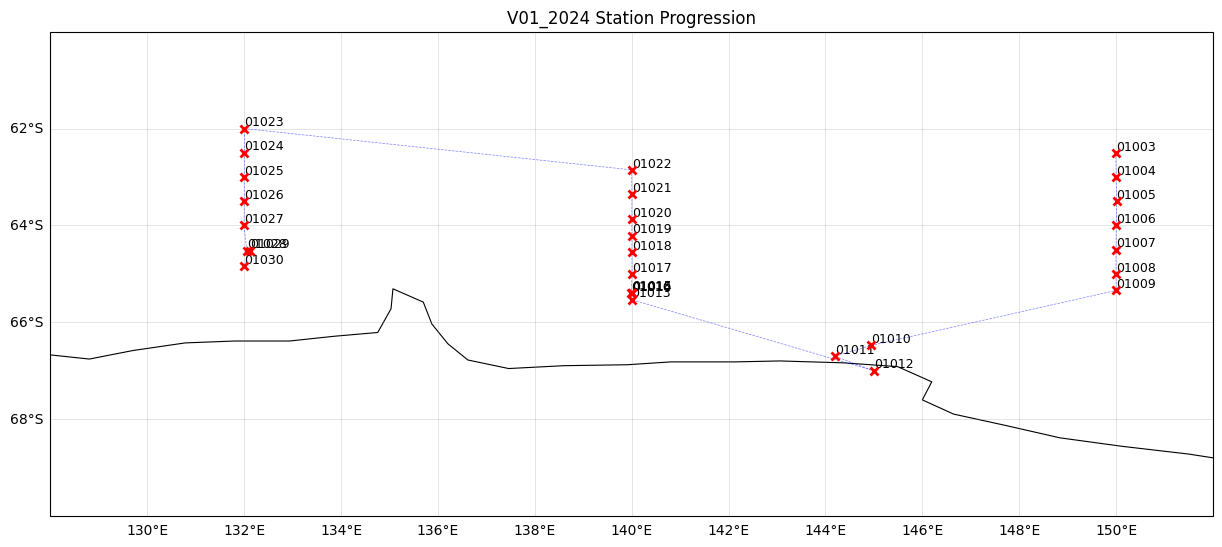

In [28]:
proj = ccrs.PlateCarree()

lon_min, lon_max = 128, 152
lat_min, lat_max = -60, -70

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs = proj)

# Coastlines
ax.coastlines(resolution='110m', linewidth=0.8)

mean_lon = np.array(mean_lon)
mean_lat = np.array(mean_lat)
stations_all = np.array(stations_all)

mask = (
    (mean_lat <= lat_min) & (mean_lat >= lat_max) &
    (mean_lon >= lon_min) & (mean_lon <= lon_max)
)

mean_lon_plot = mean_lon[mask]
mean_lat_plot = mean_lat[mask]
stations_plot = stations_all[mask]


# Line (transparent)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='--',
    color='blue',
    linewidth=0.5,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# Markers (fully opaque)
ax.plot(
    mean_lon_plot,
    mean_lat_plot,
    linestyle='None',
    marker='x',
    color='red',
    markersize=6,
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# stations = ['001', '002', '003', '004', '005', '006', '007', '008', '009','010', '011', '012', '013']

# Label stations
for stn, lon, lat in zip(stations_plot, mean_lon_plot, mean_lat_plot):
    ax.text(
        lon, lat, stn,
        transform=ccrs.PlateCarree(),
        fontsize=9,
        ha='left',
        va='bottom'
    )

# -------------------------
# Gridlines + lon/lat ticks
# -------------------------
lon_ticks = np.arange(-180, 181, 2)   # adjust spacing as needed
lat_ticks = np.arange(-90, 91, 2)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='-',
    xlocs=lon_ticks,
    ylocs=lat_ticks
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_ylim(lat_max, lat_min)

ax.set_title("V01_2024 Station Progression")

plt.show()


In [8]:
mean_lon = []
mean_lat = []

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

for stn in line_132:
    ds = datasets[stn]

    # Extract coordinates
    lon = ds.coords["longitude"].values
    lat = ds.coords["latitude"].values
    pressure = ds.coords["pressure"].values   # <-- FIXED

    # # Apply mask
    # mask = pressure > 8.5
    # longitude = lon[mask]
    # latitude = lat[mask]

    lon_mean = np.mean(lon)
    lat_mean = np.mean(lat)

    mean_lon.append(lon_mean)
    mean_lat.append(lat_mean)

    print(f"Mean lon/lat at {stn}: {lon_mean:.4f} / {lat_mean:.4f}")


Mean lon/lat at 01023: 132.0022 / -62.0001
Mean lon/lat at 01024: 132.0032 / -62.5000
Mean lon/lat at 01025: 132.0012 / -63.0015
Mean lon/lat at 01026: 132.0011 / -63.5010
Mean lon/lat at 01027: 131.9981 / -64.0012
Mean lon/lat at 01028: 132.0513 / -64.5211
Mean lon/lat at 01029: 132.1247 / -64.5235
Mean lon/lat at 01030: 131.9942 / -64.8403


In [9]:
ds_01028 = datasets['01028']
stn = '01028'
print(list(ds_01028.attrs['WaterDepth']))

['1', '5', '1', '6', '.', '8', '6']


In [10]:
print(ds_01028['woce_date'])

<xarray.DataArray 'woce_date' (time: 1)> Size: 8B
[1 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-26T21:52:42.335000064
Attributes:
    long_name:      WOCE date
    standard_name:  Date
    units:          yyyymmdd UTC
    data_min:       20240126.0
    data_max:       20240126.0
    valid_range:    [20240126. 20240126.]


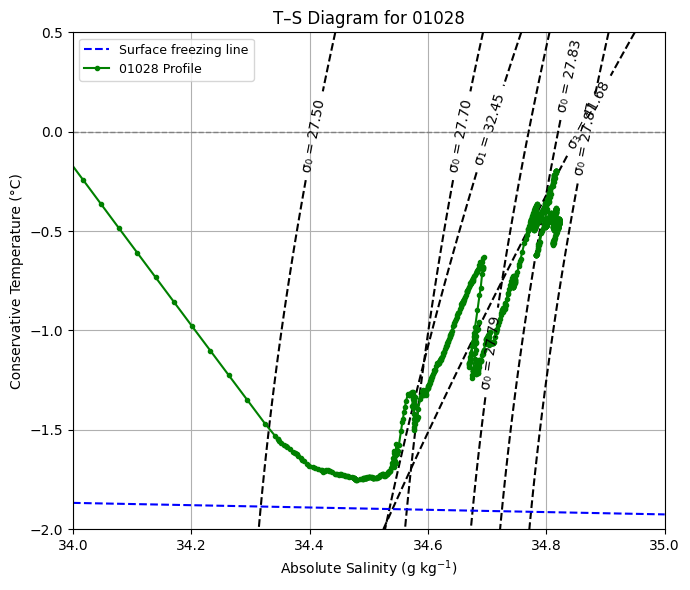

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gsw  # Gibbs SeaWater library



# Example station/cast
stn = '01028'

# Cast data
sal = ds_01028['salinity'].values.squeeze()        # Practical Salinity [PSU]
temp = ds_01028['temperature'].values.squeeze()    # In-situ Temperature [°C]
p = ds_01028['pressure'].values.squeeze()             # Pressure [dbar]

# Cast location
lon = 132.0513
lat = -64.5211


SA = gsw.SA_from_SP(sal, p, lon, lat)   # Absolute Salinity [g/kg]
CT = gsw.CT_from_t(SA, temp, p)        # Conservative Temperature [°C]



xmin, xmax = 34, 35      # SA range
ymin, ymax = -2, 0.5     # CT range

# Grid for contours
s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

# Surface freezing temperature
surface_fp = -1.9

# Isopycnal levels
pd_0 = [27.50, 27.70, 27.79, 27.83, 27.87]  # sigma-0
pd_1 = [32.45]                               # sigma-1
pd_3 = [41.68]                               # sigma-3

# Compute density fields
sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)



fig, ax = plt.subplots(figsize=(7, 6))

# Sigma-0 contours
cs0 = ax.contour(
    Sg, Tg, sigma0_grid,
    levels=pd_0,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs0, fmt='σ₀ = %.2f')

# Sigma-1 contour
cs1 = ax.contour(
    Sg, Tg, sigma1_grid,
    levels=pd_1,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs1, fmt='σ₁ = %.2f')

# Sigma-3 contour
cs3 = ax.contour(
    Sg, Tg, sigma3_grid,
    levels=pd_3,
    colors='black',
    linestyles='--',
    linewidths=1.5
)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Surface freezing line (~10 dbar)
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),  # approximate surface freezing line
    color='blue',
    linewidth=1.5,
    linestyle='--',
    label='Surface freezing line'
)

ax.plot(
    SA, CT,
    marker='o',
    linestyle='-',
    markersize=3,
    color='green',
    label=f'{stn} Profile'
)

# Optional horizontal reference line at 0°C
ax.axhline(0, color='grey', linestyle='--', linewidth=1)



ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title(f'T–S Diagram for {stn}')
ax.grid(True)


ax.legend(loc = 'upper left', fontsize = 9, frameon = True)

plt.tight_layout()
plt.show()


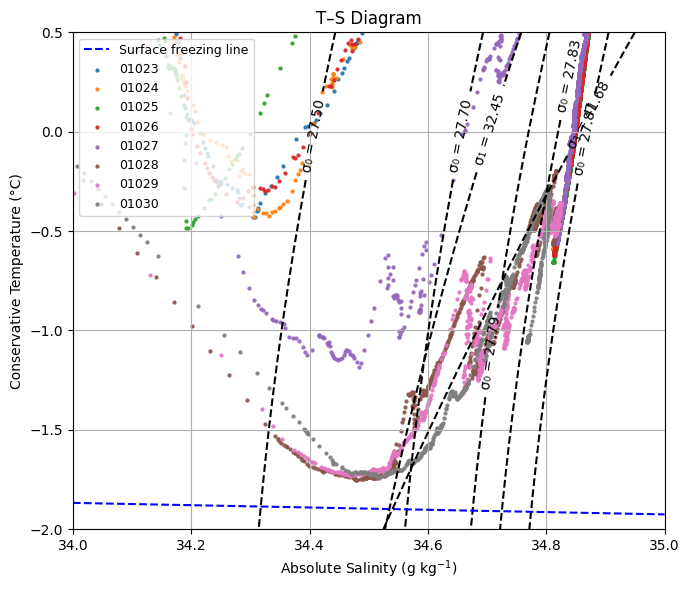

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gsw

# -------------------------------------------------
# 1. DEFINE YOUR STATIONS AND DATASETS
# -------------------------------------------------

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

# -------------------------------------------------
# 2. SET UP T–S DIAGRAM GRID
# -------------------------------------------------

xmin, xmax = 34, 35
ymin, ymax = -2, 0.5

s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

pd_0 = [27.50, 27.70, 27.79, 27.83, 27.87]
pd_1 = [32.45]
pd_3 = [41.68]

sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# -------------------------------------------------
# 3. CREATE FIGURE
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 6))

# Isopycnals
cs0 = ax.contour(Sg, Tg, sigma0_grid, levels=pd_0,
                 colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs0, fmt='σ₀ = %.2f')

cs1 = ax.contour(Sg, Tg, sigma1_grid, levels=pd_1,
                 colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs1, fmt='σ₁ = %.2f')

cs3 = ax.contour(Sg, Tg, sigma3_grid, levels=pd_3,
                 colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs3, fmt='σ₃ = %.2f')

# Surface freezing line
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),
    color='blue',
    linestyle='--',
    linewidth=1.5,
    label='Surface freezing line'
)

# -------------------------------------------------
# 4. LOOP THROUGH STATIONS
# -------------------------------------------------

for stn in line_132:

    ds = datasets[stn]   # directly access dataset

    # Extract profile data
    sal = ds['salinity'].values.squeeze()
    temp = ds['temperature'].values.squeeze()
    p = ds['pressure'].values.squeeze()

    lon = ds['longitude'].values.item()
    lat = ds['latitude'].values.item()

    # Convert to Absolute Salinity & Conservative Temp
    SA = gsw.SA_from_SP(sal, p, lon, lat)
    CT = gsw.CT_from_t(SA, temp, p)

    ax.scatter(
    SA,
    CT,
    s=5,
    linewidth=0.8,
    alpha=0.9,
    label=f'{stn}'
)

    # # ---- Bottom 100 dbar average ----
    # p_max = np.nanmax(p)
    # bottom_mask = p >= (p_max - 100)
    #
    # SA_mean = np.nanmean(SA[bottom_mask])
    # CT_mean = np.nanmean(CT[bottom_mask])

    # ax.scatter(
    #     SA_mean,
    #     CT_mean,
    #     s=60,
    #     edgecolor='k',
    #     linewidth=0.8,
    #     alpha=0.9,
    #     label=f'{stn}'
    # )

# -------------------------------------------------
# 5. FORMAT PLOT
# -------------------------------------------------

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram')
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


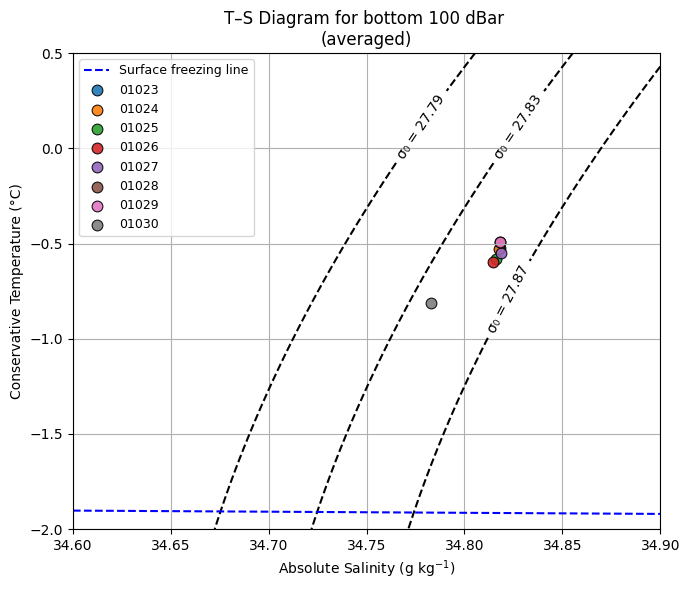

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gsw

# -------------------------------------------------
# 1. DEFINE YOUR STATIONS AND DATASETS
# -------------------------------------------------

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

# -------------------------------------------------
# 2. SET UP T–S DIAGRAM GRID
# -------------------------------------------------

xmin, xmax = 34.6, 34.9
ymin, ymax = -2, 0.5

s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)
Sg, Tg = np.meshgrid(s_grid, t_grid)

pd_0 = [ 27.79, 27.83, 27.87]
pd_1 = [32.45]
pd_3 = [41.68]

sigma0_grid = gsw.sigma0(Sg, Tg)
sigma1_grid = gsw.sigma1(Sg, Tg)
sigma3_grid = gsw.sigma3(Sg, Tg)

# -------------------------------------------------
# 3. CREATE FIGURE
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 6))

# Isopycnals
cs0 = ax.contour(Sg, Tg, sigma0_grid, levels=pd_0,
                 colors='black', linestyles='--', linewidths=1.5)
ax.clabel(cs0, fmt='σ₀ = %.2f')

# cs1 = ax.contour(Sg, Tg, sigma1_grid, levels=pd_1,
#                  colors='black', linestyles='--', linewidths=1.5)
# ax.clabel(cs1, fmt='σ₁ = %.2f')
#
# cs3 = ax.contour(Sg, Tg, sigma3_grid, levels=pd_3,
#                  colors='black', linestyles='--', linewidths=1.5)
# ax.clabel(cs3, fmt='σ₃ = %.2f')

# Surface freezing line
ax.plot(
    s_grid,
    gsw.CT_freezing(s_grid, 0, 10),
    color='blue',
    linestyle='--',
    linewidth=1.5,
    label='Surface freezing line'
)

# -------------------------------------------------
# 4. LOOP THROUGH STATIONS
# -------------------------------------------------

for stn in line_132:

    ds = datasets[stn]   # directly access dataset

    # Extract profile data
    sal = ds['salinity'].values.squeeze()
    temp = ds['temperature'].values.squeeze()
    p = ds['pressure'].values.squeeze()

    lon = ds['longitude'].values.item()
    lat = ds['latitude'].values.item()

    # Convert to Absolute Salinity & Conservative Temp
    SA = gsw.SA_from_SP(sal, p, lon, lat)
    CT = gsw.CT_from_t(SA, temp, p)


    # ---- Bottom 100 dbar average ----
    p_max = np.nanmax(p)
    bottom_mask = p >= (p_max - 100)

    SA_mean = np.nanmean(SA[bottom_mask])
    CT_mean = np.nanmean(CT[bottom_mask])

    ax.scatter(
        SA_mean,
        CT_mean,
        s=60,
        edgecolor='k',
        linewidth=0.8,
        alpha=0.9,
        label=f'{stn}'
    )

# -------------------------------------------------
# 5. FORMAT PLOT
# -------------------------------------------------

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Absolute Salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative Temperature (°C)')
ax.set_title('T–S Diagram for bottom 100 dBar \n(averaged)')
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


01023 max p: 4559.637069084115 valid bottom points: 101 SA_mean: 34.81818791795733 CT_mean: -0.5254654087663957 rho: 1048.3443666966482
01024 max p: 4519.0 valid bottom points: 101 SA_mean: 34.81756694882394 CT_mean: -0.5300959532609298 rho: 1048.1695042347355
01025 max p: 4374.0 valid bottom points: 101 SA_mean: 34.8162605480386 CT_mean: -0.5820147064898873 rho: 1047.5508625445616
01026 max p: 4072.0 valid bottom points: 101 SA_mean: 34.81464045586094 CT_mean: -0.5955450116639158 rho: 1046.2396122464877
01027 max p: 3261.0 valid bottom points: 101 SA_mean: 34.81872785066354 CT_mean: -0.549943044620086 rho: 1042.6658394666672
01028 max p: 1515.5812403656753 valid bottom points: 101 SA_mean: 34.818297404911775 CT_mean: -0.4935243626684412 rho: 1034.7456611457708
01029 max p: 1333.7548416139232 valid bottom points: 101 SA_mean: 34.818133445261594 CT_mean: -0.4906490419616387 rho: 1033.9026192508495
01030 max p: 973.5287475585938 valid bottom points: 101 SA_mean: 34.78283428771208 CT_mean

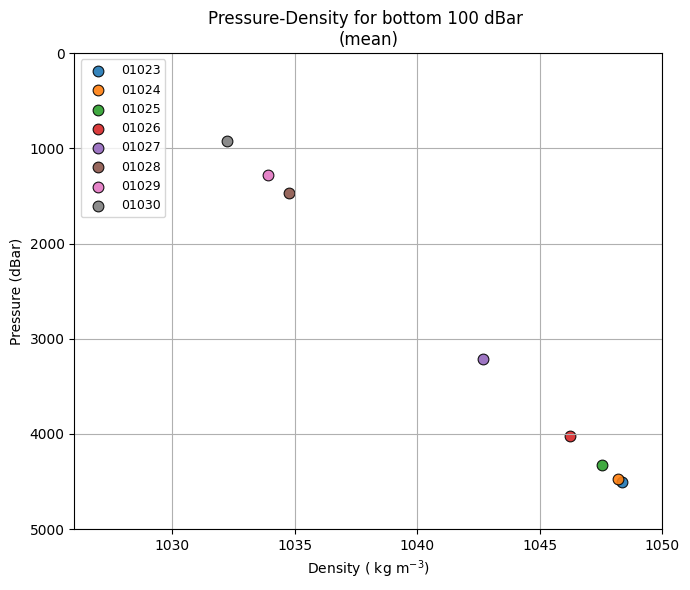

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import gsw

# -------------------------------------------------
# 1. DEFINE YOUR STATIONS AND DATASETS
# -------------------------------------------------

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

# -------------------------------------------------
# 2. SET UP T–S DIAGRAM GRID
# -------------------------------------------------

xmin, xmax = 1026, 1050
ymin, ymax = 0, 5000

s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)

# -------------------------------------------------
# 3. CREATE FIGURE
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 6))

# -------------------------------------------------
# 4. LOOP THROUGH STATIONS
# -------------------------------------------------

for stn in line_132:

    ds = datasets[stn]   # directly access dataset

    # Extract profile data
    sal = ds['salinity'].values.squeeze()
    temp = ds['temperature'].values.squeeze()
    p = ds['pressure'].values.squeeze()

    lon = ds['longitude'].values.item()
    lat = ds['latitude'].values.item()

    # Convert to Absolute Salinity & Conservative Temp
    SA = gsw.SA_from_SP(sal, p, lon, lat)
    CT = gsw.CT_from_t(SA, temp, p)


    # ---- Bottom 100 dbar average ----
    p_max = np.nanmax(p)
    p_ave = p_max-50

    bottom_mask = p >= (p_max - 100)

    SA_mean = np.nanmean(SA[bottom_mask])
    CT_mean = np.nanmean(CT[bottom_mask])

    rho = gsw.rho(SA_mean, CT_mean, p_ave)

    print(stn,
      "max p:", p_max,
      "valid bottom points:", np.sum(bottom_mask),
      "SA_mean:", SA_mean,
      "CT_mean:", CT_mean,
          "rho:", rho,)


    ax.scatter(
        rho,
        p_ave,
        s=60,
        edgecolor='k',
        linewidth=0.8,
        alpha=0.9,
        label=f'{stn}'
    )

# -------------------------------------------------
# 5. FORMAT PLOT
# -------------------------------------------------

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.invert_yaxis()
ax.set_xlabel('Density ( kg m$^{-3}$)')
ax.set_ylabel('Pressure (dBar)')
ax.set_title('Pressure-Density for bottom 100 dBar \n(mean)')
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


01023 skipped (deeper than plot limit)
01024 skipped (deeper than plot limit)
01025 skipped (deeper than plot limit)
01026 skipped (deeper than plot limit)
01027 skipped (deeper than plot limit)
01028 max p: 1515.5812403656753 valid bottom points: 101 SA_mean: 34.818297404911775 CT_mean: -0.4935243626684412 sigma0: 27.853407329666425
01029 max p: 1333.7548416139232 valid bottom points: 101 SA_mean: 34.818133445261594 CT_mean: -0.4906490419616387 sigma0: 27.853141117257564
01030 max p: 973.5287475585938 valid bottom points: 101 SA_mean: 34.78283428771208 CT_mean: -0.8148190715920428 sigma0: 27.839150048912643


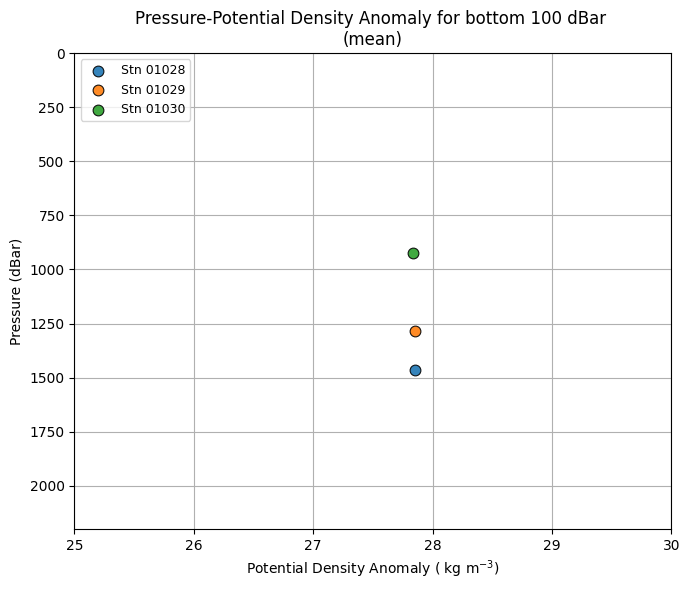

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gsw

# -------------------------------------------------
# 1. DEFINE YOUR STATIONS AND DATASETS
# -------------------------------------------------

line_132 = ['01023', '01024', '01025', '01026', '01027', '01028', '01029', '01030']

# -------------------------------------------------
# 2. SET UP T–S DIAGRAM GRID
# -------------------------------------------------


xmin, xmax = 25, 30
ymin, ymax = 0, 2200
# ymin, ymax = 0, 5000

s_grid = np.linspace(xmin, xmax, 150)
t_grid = np.linspace(ymin, ymax, 150)

# -------------------------------------------------
# 3. CREATE FIGURE
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(7, 6))

# -------------------------------------------------
# 4. LOOP THROUGH STATIONS
# -------------------------------------------------

for stn in line_132:

    ds = datasets[stn]   # directly access dataset

    # Extract profile data
    sal = ds['salinity'].values.squeeze()
    temp = ds['temperature'].values.squeeze()
    p = ds['pressure'].values.squeeze()

    p_max = np.nanmax(p)

    if p_max > ymax:
        print(f"{stn} skipped (deeper than plot limit)")
        continue


    lon = ds['longitude'].values.item()
    lat = ds['latitude'].values.item()

    # Convert to Absolute Salinity & Conservative Temp
    SA = gsw.SA_from_SP(sal, p, lon, lat)
    CT = gsw.CT_from_t(SA, temp, p)


    # ---- Bottom 100 dbar average ----
    p_max = np.nanmax(p)
    p_ave = p_max-50

    bottom_mask = p >= (p_max - 100)

    SA_mean = np.nanmean(SA[bottom_mask])
    CT_mean = np.nanmean(CT[bottom_mask])

    sigma0 = gsw.sigma0(SA_mean, CT_mean)

    print(stn,
      "max p:", p_max,
      "valid bottom points:", np.sum(bottom_mask),
      "SA_mean:", SA_mean,
      "CT_mean:", CT_mean,
          "sigma0:", sigma0,)

    # Plot averaged point
    ax.scatter(
        sigma0,
        p_ave,
        s=60,
        edgecolor='k',
        linewidth=0.8,
        alpha=0.9,
        label=f'Stn {stn}'
    )

# -------------------------------------------------
# 5. FORMAT PLOT
# -------------------------------------------------

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.invert_yaxis()
ax.set_xlabel('Potential Density Anomaly ( kg m$^{-3}$)')
ax.set_ylabel('Pressure (dBar)')
ax.set_title('Pressure-Potential Density Anomaly for bottom 100 dBar \n(mean)')
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import xarray as xr
import gsw

# Lists to store output
sigma0_list = []
p_list = []
station_list = []

ymax = 2200  # maximum depth for inclusion

for stn in line_132:

    ds = datasets[stn]

    # Extract profile
    sal = ds['salinity'].values.squeeze()
    temp = ds['temperature'].values.squeeze()
    p = ds['pressure'].values.squeeze()

    # p_max = np.nanmax(p)
    #
    # # Skip stations deeper than ymax
    # if p_max > ymax:
    #     print(f"{stn} skipped (deeper than plot limit)")
    #     continue

    lon = ds['longitude'].values.item()
    lat = ds['latitude'].values.item()

    # Convert to Absolute Salinity & Conservative Temperature
    SA = gsw.SA_from_SP(sal, p, lon, lat)
    CT = gsw.CT_from_t(SA, temp, p)

    # Bottom 100 dbar mask
    bottom_mask = p >= (p_max - 100)

    SA_mean = np.nanmean(SA[bottom_mask])
    CT_mean = np.nanmean(CT[bottom_mask])
    p_mean = np.nanmean(p[bottom_mask])

    sigma0 = gsw.sigma0(SA_mean, CT_mean)

    # Append to lists
    station_list.append(stn)
    sigma0_list.append(sigma0)
    p_list.append(p_mean)

    print(stn,
          "max p:", p_max,
          "valid bottom points:", np.sum(bottom_mask),
          "SA_mean:", SA_mean,
          "CT_mean:", CT_mean,
          "sigma0:", sigma0)


01023 max p: 973.5287475585938 valid bottom points: 3687 SA_mean: 34.86705086172583 CT_mean: 0.4482200639983791 sigma0: 27.842488216101856
01024 max p: 973.5287475585938 valid bottom points: 3646 SA_mean: 34.86621125274798 CT_mean: 0.42892155580370606 sigma0: 27.84296183557217
01025 max p: 973.5287475585938 valid bottom points: 3501 SA_mean: 34.867828977591515 CT_mean: 0.4558821970695101 sigma0: 27.842655134736106
01026 max p: 973.5287475585938 valid bottom points: 3199 SA_mean: 34.86209875432243 CT_mean: 0.32989822414610565 sigma0: 27.845469527518844
01027 max p: 973.5287475585938 valid bottom points: 2388 SA_mean: 34.84658088139741 CT_mean: 0.05360578292412068 sigma0: 27.848517137992303
01028 max p: 973.5287475585938 valid bottom points: 643 SA_mean: 34.814369838388615 CT_mean: -0.456392019535661 sigma0: 27.848505406767345
01029 max p: 973.5287475585938 valid bottom points: 461 SA_mean: 34.81815368002806 CT_mean: -0.4476585247609204 sigma0: 27.851135148178173
01030 max p: 973.5287475

In [17]:
ds_out = xr.Dataset(
    {
        "sigma0_bottom_mean": (["station"], sigma0_list),
        "pressure_bottom_mean": (["station"], p_list),
    },
    coords={
        "station": station_list
    }
)

# Add metadata
ds_out["sigma0_bottom_mean"].attrs["units"] = "kg m-3"
ds_out["pressure_bottom_mean"].attrs["units"] = "dbar"
ds_out.attrs["description"] = "Bottom 100 dbar mean properties for stations in line_132"
ds_out.to_netcdf("in2024_bottom_100dbar_sigma0.nc")

In [18]:
in2024_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2024_bottom_100dbar_sigma0.nc')
in2026_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2026_bottom_100dbar_sigma0.nc')



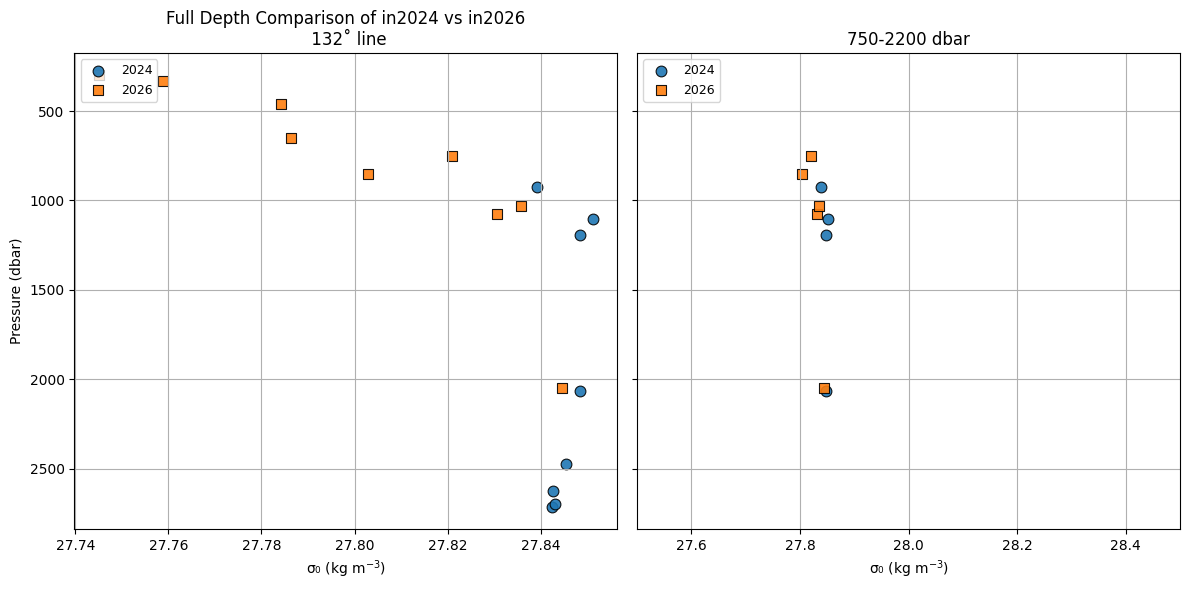

In [19]:
import matplotlib.pyplot as plt
import xarray as xr

# Load datasets
in2024_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2024_bottom_100dbar_sigma0.nc')
in2026_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2026_bottom_100dbar_sigma0.nc')

# Extract variables
stations_2024 = in2024_ds["station"].values
sigma0_2024 = in2024_ds["sigma0_bottom_mean"].values
p_2024 = in2024_ds["pressure_bottom_mean"].values

stations_2026 = in2026_ds["station"].values
sigma0_2026 = in2026_ds["sigma0_bottom_mean"].values
p_2026 = in2026_ds["pressure_bottom_mean"].values

# User-defined zoom limits
zoom_ymin, zoom_ymax = 750, 2200
zoom_xmin, zoom_xmax = 27.5, 28.5  # replace with your desired sigma0 range

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax = axes[0]
ax.scatter(sigma0_2024, p_2024, s=60, edgecolor='k', linewidth=0.8,
           alpha=0.9, label='2024')
ax.scatter(sigma0_2026, p_2026, s=60, edgecolor='k', linewidth=0.8,
           alpha=0.9, label='2026', marker='s')
ax.set_xlabel('σ₀ (kg m$^{-3}$)')
ax.set_ylabel('Pressure (dbar)')
ax.invert_yaxis()
ax.set_title('Full Depth Comparison of in2024 vs in2026\n 132˚ line')
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

ax = axes[1]

# Apply zoom mask
mask_2024 = (p_2024 >= zoom_ymin) & (p_2024 <= zoom_ymax)
mask_2026 = (p_2026 >= zoom_ymin) & (p_2026 <= zoom_ymax)

ax.scatter(sigma0_2024[mask_2024], p_2024[mask_2024], s=60,
           edgecolor='k', linewidth=0.8, alpha=0.9, label='2024')
ax.scatter(sigma0_2026[mask_2026], p_2026[mask_2026], s=60,
           edgecolor='k', linewidth=0.8, alpha=0.9, label='2026', marker='s')

ax.set_xlabel('σ₀ (kg m$^{-3}$)')
ax.set_title(f'{zoom_ymin}-{zoom_ymax} dbar')
ax.set_xlim(zoom_xmin, zoom_xmax)
ax.grid(True)
ax.legend(loc='upper left', fontsize=9, frameon=True)

plt.tight_layout()
plt.show()


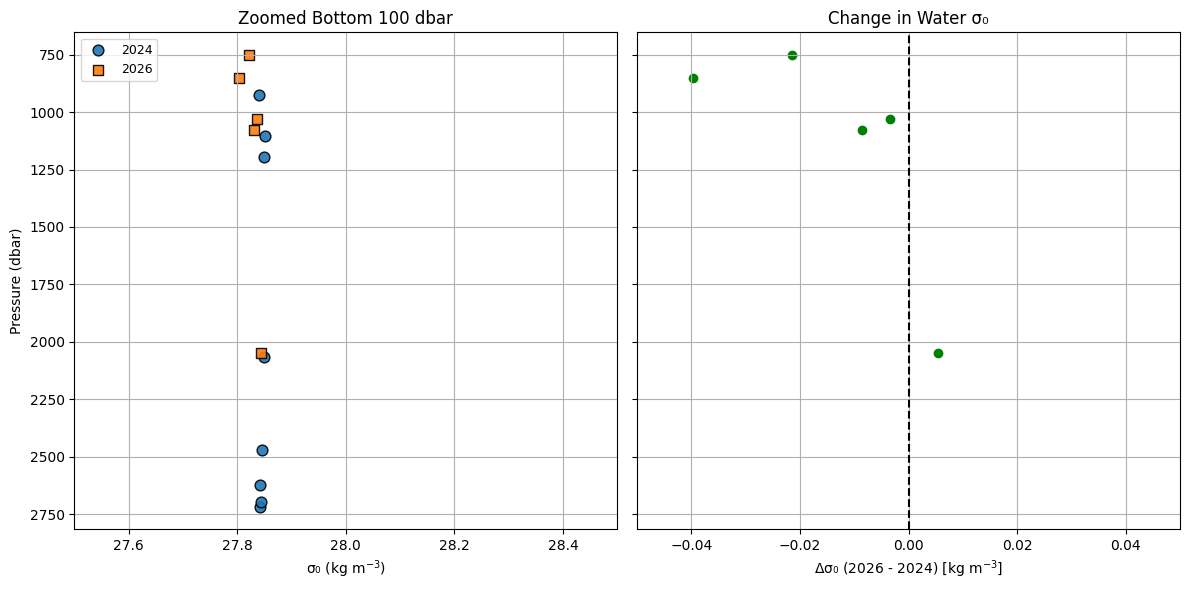

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Load datasets
in2024_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2024_bottom_100dbar_sigma0.nc')
in2026_ds = xr.open_dataset('/Users/iw2g24/PycharmProjects/COOKIES/in2026_bottom_100dbar_sigma0.nc')

# Extract arrays
p_2024 = in2024_ds['pressure_bottom_mean'].values
sigma0_2024 = in2024_ds['sigma0_bottom_mean'].values

p_2026 = in2026_ds['pressure_bottom_mean'].values
sigma0_2026 = in2026_ds['sigma0_bottom_mean'].values

# Zoom region
zoom_ymin, zoom_ymax = 750, 2200
zoom_xmin, zoom_xmax = 27.5, 28.5

# ------------------------
# Only keep 2024 points that exist in 2026
# ------------------------
mask_2026 = (p_2026 >= zoom_ymin) & (p_2026 <= zoom_ymax)

# ------------------------
# Only keep 2026 points in zoom region
# ------------------------
mask_2026 = (p_2026 >= zoom_ymin) & (p_2026 <= zoom_ymax)

p_2026_masked = p_2026[mask_2026]
sigma0_2026_masked = sigma0_2026[mask_2026]

# ------------------------
# Interpolate 2024 σ₀ onto 2026 pressure points
# ------------------------
sigma0_2024_interp = np.interp(p_2026_masked, p_2024, sigma0_2024)

# Compute difference
delta_sigma0 = sigma0_2026_masked - sigma0_2024_interp

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left: scatter plot of 2024 and 2026 (zoomed)
ax = axes[0]
ax.scatter(sigma0_2024, p_2024, s=60, edgecolor='k', alpha=0.9, label='2024')
ax.scatter(sigma0_2026_masked, p_2026_masked, s=60, edgecolor='k', alpha=0.9, label='2026', marker='s')
ax.set_xlabel('σ₀ (kg m$^{-3}$)')
ax.set_ylabel('Pressure (dbar)')
ax.set_title(f'Zoomed Bottom 100 dbar')
ax.set_xlim(zoom_xmin, zoom_xmax)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper left', fontsize=9)

# Right: Δσ₀
ax = axes[1]
ax.scatter(delta_sigma0, p_2026_masked, color='green', linewidth=1)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel('Δσ₀ (2026 - 2024) [kg m$^{-3}$]')
ax.set_title('Change in Water σ₀')
ax.set_xlim(-0.05, 0.05)  # adjust depending on typical density change
ax.grid(True)

plt.tight_layout()
plt.show()

